# Supervised Group Project

## Data Exploration

### Data Types

In [67]:
import pandas as pd
import numpy as np
from IPython.core.display import display, Markdown

summary = pd.read_excel('Songs_2025.xlsx', sheet_name='legend')
summary = summary.rename(columns = {'year': 'Variable', 'year.1': 'Description'})

df = pd.read_excel('Songs_2025.xlsx', sheet_name='spotify songs')
summary['Data Type'] = df.dtypes.values[1:]

md_table = summary.to_markdown(index=False)
display(Markdown(md_table))
display(Markdown('---'))

C:\Users\SABIO\AppData\Local\Temp\ipykernel_17188\3353133728.py:3: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display



| Variable          | Description                                                                                                                                                                  | Data Type   |
|:------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------|
| track_name        | track name                                                                                                                                                                   | object      |
| track_popularity  | track popularity from 0 to 100                                                                                                                                               | int64       |
| album             | album the track appears on                                                                                                                                                   | object      |
| artist_name       | artist name                                                                                                                                                                  | object      |
| artist_genres     | list of the Genres the artist is associated with                                                                                                                             | object      |
| artist_popularity | artist popularity from 0 to 100, being the maximum                                                                                                                           | int64       |
| danceability      | a value of 0.0 is least danceable and 1.0 is most danceable                                                                                                                  | float64     |
| energy            | a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity, being 1.0 the maximum                                                               | float64     |
| key               | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C,  1 = C♯/D♭,  2 = D  and so on                                              | float64     |
| loudness          | The overall loudness of a track in decibels (dB)                                                                                                                             | float64     |
| mode              | Modality (major or minor) of a track. Major = 1 and minor = 0                                                                                                                | float64     |
| speechiness       | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. | float64     |
| acousticness      | A confidence measure from 0.0 to 1.0 of whether the track is acoustic                                                                                                        | float64     |
| instrumentalness  | Predicts whether a track contains no vocals                                                                                                                                  | float64     |
| liveness          | Detects the presence of an audience in the recording                                                                                                                         | float64     |
| valence           | a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track                                                                                            | float64     |
| tempo             | The overall estimated tempo of a track in beats per minute (BPM)                                                                                                             | float64     |
| duration_ms       | The duration of the track in milliseconds                                                                                                                                    | float64     |

---

### Handling Null Values

In [68]:
# Check for Missing Values
pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'})

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,1
energy,1
key,1


In [69]:
# Where the missing values are coming from
missing_value = df[df.isnull().any(axis = 1)]
display(missing_value)
# display(Markdown(f'Considering there is only one track, {missing_value['track_name'].values[0]} with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.'))
display(Markdown('Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.'))

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
488,2004,These Words,68,Unwritten,Natasha Bedingfield,['dance pop'; 'pop'; 'post-teen pop'],64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.

In [70]:
# Dropping the null row
df = df.drop(index = missing_value.index.item())
pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'})

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,0
energy,0
key,0


### Handling Artists Genres

Two different approaches. First one takes the first value in the list of artist genres and assumes that it is the most important creating a new column called **dominant_genre_first**. 
  
`Example: ['pop', 'rock'] = pop`  
  
The second approach will split by every word and count the word that appears the most in the list. If there is an instance where it is only one genre but the genre is two words, it will take the second word and if it is only one word, will take just that word.  
  
`Example: ['pop', 'rock', 'country pop'] = pop`   
`Example: ['british soul'] = soul`  
`Example: ['country'] = country`  

In [71]:
# Dominant Genre based on first value in list
import re

def extract_first_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return the
    first value in the list of genres. (Assumes the first genre in the list is most important)
    """
    cleaned_genre = re.sub(r"[\[\]']", "", genre_str).strip()  
    genre_list = cleaned_genre.split(';')
        
    return genre_list[0].strip() 


df['dominant_genre_first'] = df['artist_genres'].apply(extract_first_genre)

In [72]:
# Dominant value based on most occuring word
import re

def clean_and_extract_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return a list of 
    words from the string. If the string only has one genre, it will take the second word as the dominant genre.
    If there are more words, then it will count the individual words and return the word that occurs the most.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = cleaned_genre.split(';')
        
        words = [word for genre in genre_list for word in genre.split()]
        
        #No words
        if not words:
            return 'Unknown'
        
        #One word
        if len(genre_list) == 1:
            return words[1] if len(words) > 1 else words[0]
        
        #Multiple words
        return max(words, key=words.count)

    return 'Unknown'

df['dominant_genre_max'] = df['artist_genres'].apply(clean_and_extract_genre)

In [76]:
# Dominant value based on a predefined word list
import re

target_genres = {'rock', 'pop', 'hip hop', 'jazz', 'electronic', 'classical', 'blues', 
                 'country', 'metal', 'reggae', 'country pop', 'trap', 'house', 'techno'}

def extract_matching_genre(genre_str, target_genres):
    """
    First, splits the lists into individual genres and checks if it matches the predefined list. In the
    case that there are no matches, it will then split the list of genres into individual words and
    check if they match the genre list. This helps to make sure we catch genres like hip hop but also
    genres like country pop.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = [genre.strip().lower() for genre in cleaned_genre.split(';')]
        
        for genre in genre_list:
            if genre in target_genres:
                return genre  
        
        words = [word for genre in genre_list for word in genre.split()]
        
        if "hip" in words and "hop" in words:
            return "hip hop"
        
        for word in words:
            if word in target_genres:
                return word
        
    return 'Other' 


df['matching_genre'] = df['artist_genres'].apply(lambda x: extract_matching_genre(x, target_genres))

In [77]:
display(df.head())
display(Markdown('---'))

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,dominant_genre_first,dominant_genre_max,matching_genre
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.230000,0.0,0.0951,0.888,83.014,235133.0,british soul,soul,Other
1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,['pop rock'],49,0.481,0.940,7.0,71.0,1.0,0.0660,0.000891,0.0,0.0939,0.660,96.493,189333.0,pop rock,rock,pop
2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,['dance pop'; 'pop'; 'urban contemporary'],76,0.542,0.498,1.0,80.0,1.0,0.0299,0.490000,0.0,0.1010,0.218,117.763,201933.0,dance pop,pop,pop
3,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.010300,0.0,0.6120,0.684,148.726,167067.0,alternative metal,punk,rock
4,2000,Amazed,72,Lonely Grill,Lonestar,['contemporary country'; 'country'; 'country r...,57,0.561,0.543,1.0,92.0,1.0,0.0324,0.260000,0.0,0.1240,0.243,139.803,240867.0,contemporary country,country,country


---

### Unique Values

In [78]:
rows, columns = df.shape 
print(f'Rows: {rows}, Columns: {columns}')

Rows: 2299, Columns: 22


In [79]:
unique_values = pd.DataFrame(df.nunique())
unique_values = unique_values.rename(columns = {0: 'Unique Values'})
display(unique_values)
display(Markdown('---'))

,Unique Values
year,23
track_name,2120
track_popularity,71
album,1663
artist_name,891
artist_genres,698
artist_popularity,62
danceability,585
energy,641
key,12


---

### Basic Statistics

In [58]:
# Convert categorical numeric columns to categorical type
df['mode'] = df['mode'].astype('category')
df['key'] = df['key'].astype('category')
df['year'] = df['year'].astype('category')
df['dominant_genre_first'] = df['dominant_genre_first'].astype('category')
df['dominant_genre_max'] = df['dominant_genre_max'].astype('category')

pitch_class_map = {
    0: "C",
    1: "C#/D♭",
    2: "D",
    3: "D#/E♭",
    4: "E",
    5: "F",
    6: "F#/G♭",
    7: "G",
    8: "G#/A♭",
    9: "A",
    10: "A#/B♭",
    11: "B"
}

df['pitch_class'] = df['key'].map(pitch_class_map).astype('category')

df.dtypes

year                    category
track_name                object
track_popularity           int64
album                     object
artist_name               object
artist_genres             object
artist_popularity          int64
danceability             float64
energy                   float64
key                     category
loudness                 float64
mode                    category
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
duration_ms              float64
dominant_genre_first    category
dominant_genre_max      category
Pitch Class             category
pitch_class             category
dtype: object

In [59]:
categorical_numeric_cols = ['mode', 'pitch_class', 'year', 'dominant_genre_first', 'dominant_genre_max']

# Get frequency counts for categorical numerical columns
for col in categorical_numeric_cols:
    print(f"Value counts for {col}:\n", df[col].value_counts(), "\n")

Value counts for mode:
 mode
1.0    1376
0.0     923
Name: count, dtype: int64 

Value counts for pitch_class:
 pitch_class
C#/D♭    297
C        253
G        225
B        219
F        201
D        189
A        183
G#/A♭    183
F#/G♭    177
E        152
A#/B♭    147
D#/E♭     73
Name: count, dtype: int64 

Value counts for year:
 year
2000    100
2001    100
2002    100
2003    100
2005    100
2006    100
2007    100
2015    100
2008    100
2009    100
2010    100
2011    100
2012    100
2013    100
2014    100
2019    100
2016    100
2017    100
2018    100
2021    100
2020    100
2022    100
2004     99
Name: count, dtype: int64 

Value counts for dominant_genre_first:
 dominant_genre_first
dance pop              427
pop                    256
atl hip hop             90
alternative metal       74
boy band                53
                      ... 
uk contemporary r&b      1
viral pop                1
viral rap                1
viral trap               1
vocal house              1
N

In [60]:
pd.set_option('display.max_columns', None)
df

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,dominant_genre_first,dominant_genre_max,Pitch Class,pitch_class
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.230000,0.000000,0.0951,0.888,83.014,235133.0,british soul,soul,E,E
1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,['pop rock'],49,0.481,0.940,7.0,71.0,1.0,0.0660,0.000891,0.000000,0.0939,0.660,96.493,189333.0,pop rock,rock,G,G
2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,['dance pop'; 'pop'; 'urban contemporary'],76,0.542,0.498,1.0,80.0,1.0,0.0299,0.490000,0.000000,0.1010,0.218,117.763,201933.0,dance pop,pop,C#/D♭,C#/D♭
3,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.010300,0.000000,0.6120,0.684,148.726,167067.0,alternative metal,punk,C,C
4,2000,Amazed,72,Lonely Grill,Lonestar,['contemporary country'; 'country'; 'country r...,57,0.561,0.543,1.0,92.0,1.0,0.0324,0.260000,0.000000,0.1240,0.243,139.803,240867.0,contemporary country,country,C#/D♭,C#/D♭
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,2022,We Don't Talk About Bruno,77,Encanto (Original Motion Picture Soundtrack),Carolina GaitÃ¡n - La Gaita,['movie tunes'],56,0.577,0.450,0.0,93.0,0.0,0.0834,0.357000,0.000000,0.1110,0.830,205.863,216120.0,movie tunes,tunes,C,C
2296,2022,When You're Gone,78,When You're Gone,Shawn Mendes,['canadian pop'; 'pop'; 'viral pop'],81,0.603,0.691,5.0,76.0,1.0,0.0372,0.024800,0.000000,0.5830,0.577,147.148,172267.0,canadian pop,pop,F,F
2297,2022,Where Are You Now,87,Where Are You Now,Lost Frequencies,['belgian edm'; 'edm'; 'pop dance'; 'tropical ...,76,0.671,0.636,6.0,90.0,0.0,0.1030,0.515000,0.000411,0.1720,0.262,120.966,148197.0,belgian edm,edm,F#/G♭,F#/G♭
2298,2022,Woman,87,Planet Her,Doja Cat,['dance pop'; 'pop'],86,0.824,0.764,5.0,62.0,0.0,0.0854,0.088800,0.002940,0.1170,0.881,107.998,172627.0,dance pop,pop,F,F


In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,2299.0,2011.003045,6.634528,2000.000000,2005.00000,2011.0000,2017.000000,2022.000
track_popularity,2299.0,70.944759,12.294047,0.000000,66.00000,72.0000,79.000000,100.000
artist_popularity,2299.0,72.873423,12.180506,29.000000,65.00000,74.0000,82.000000,100.000
danceability,2299.0,0.660116,0.141137,0.162000,0.57200,0.6710,0.759500,0.975
energy,2299.0,0.693047,0.164838,0.051900,0.58600,0.7120,0.820000,0.999
key,2299.0,5.277947,3.628494,0.000000,2.00000,5.0000,8.000000,11.000
loudness,2299.0,73.006960,15.643937,-56.000000,63.00000,74.0000,83.000000,132.000
mode,2299.0,0.598521,0.490304,0.000000,0.00000,1.0000,1.000000,1.000
speechiness,2299.0,0.097795,0.092445,0.022500,0.03800,0.0568,0.115500,0.576
acousticness,2299.0,0.157689,0.203844,0.000013,0.01650,0.0689,0.223000,0.978


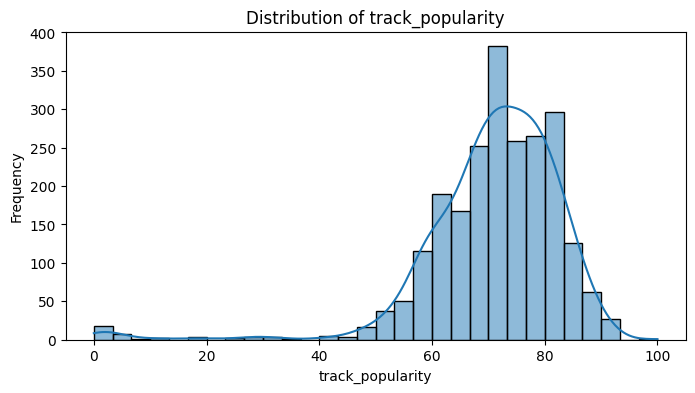

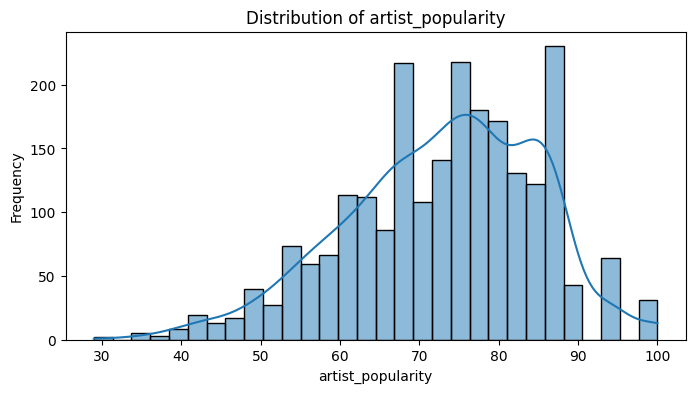

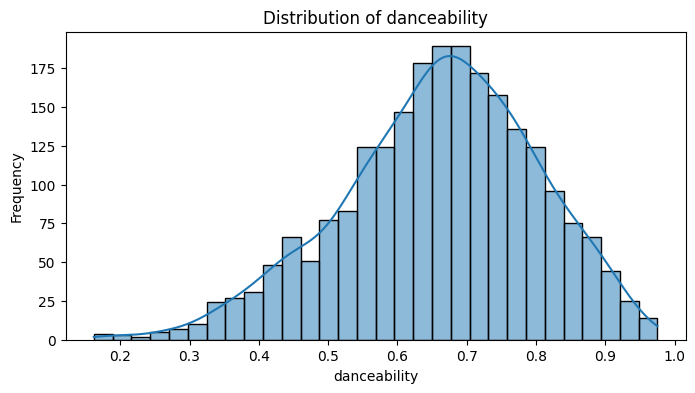

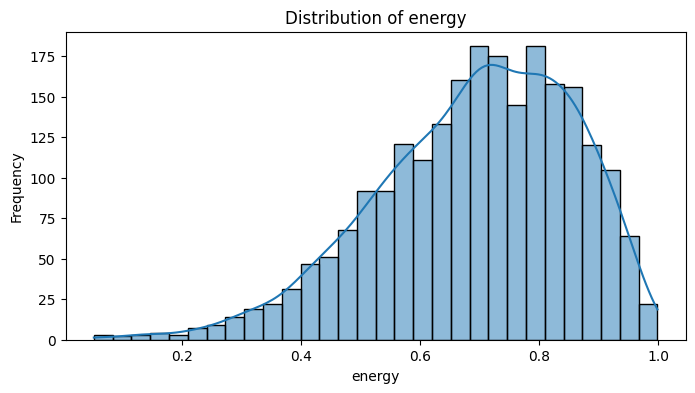

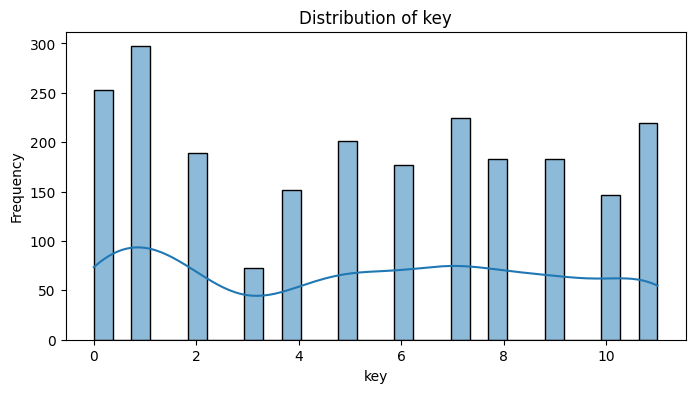

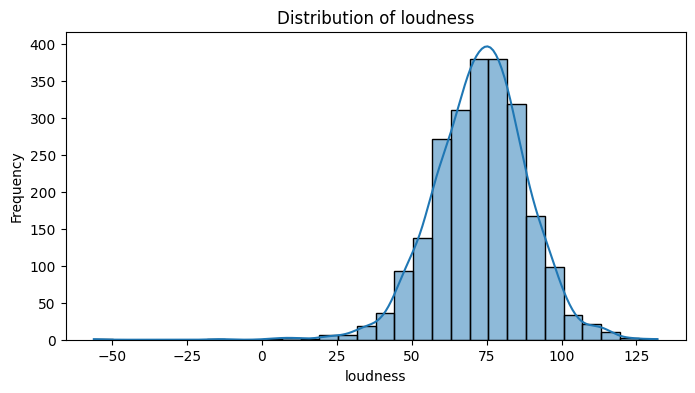

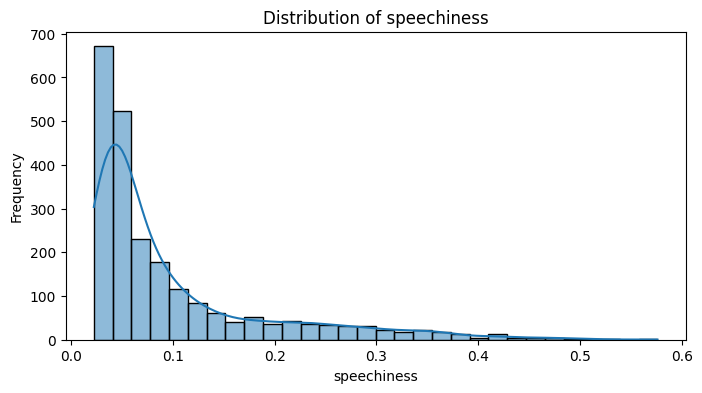

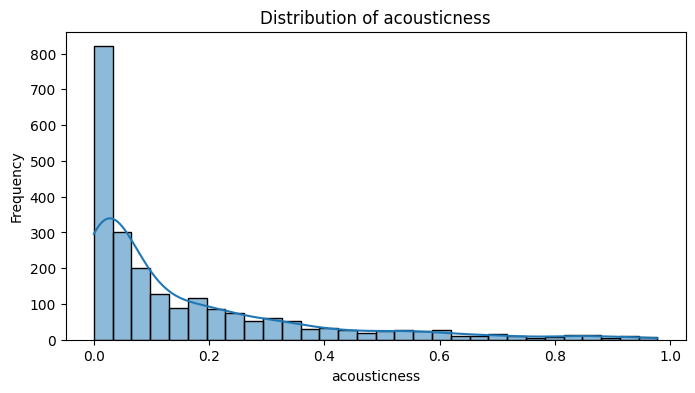

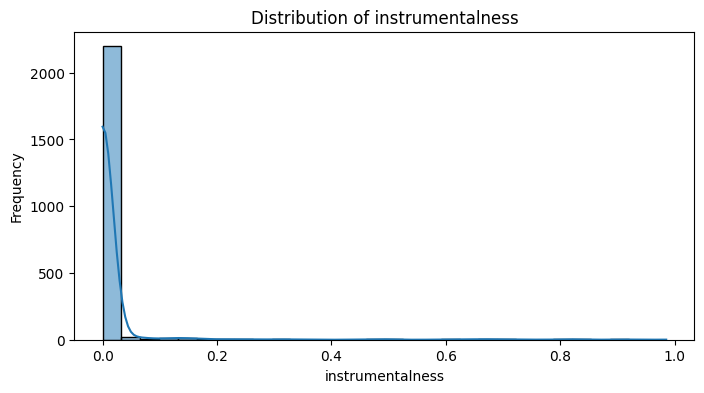

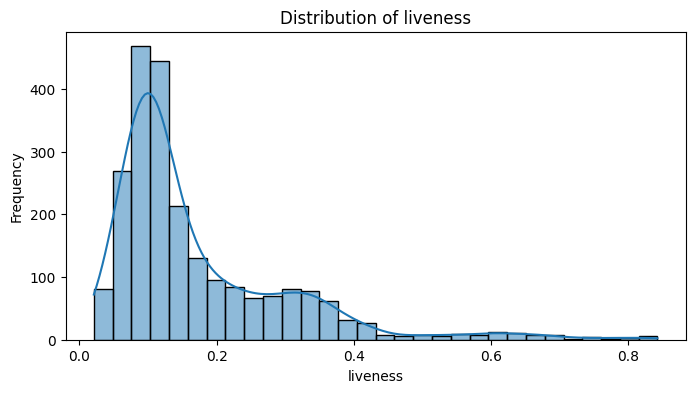

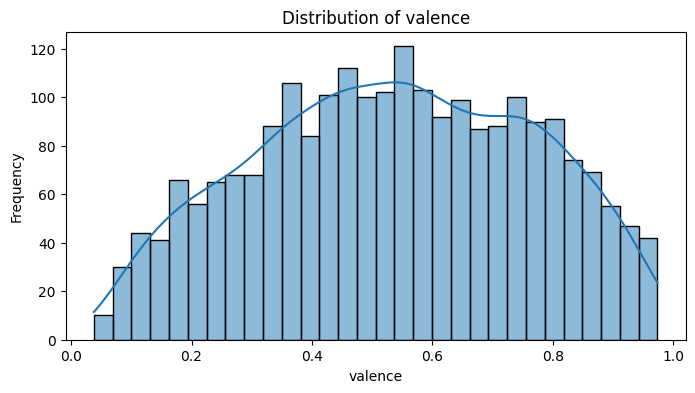

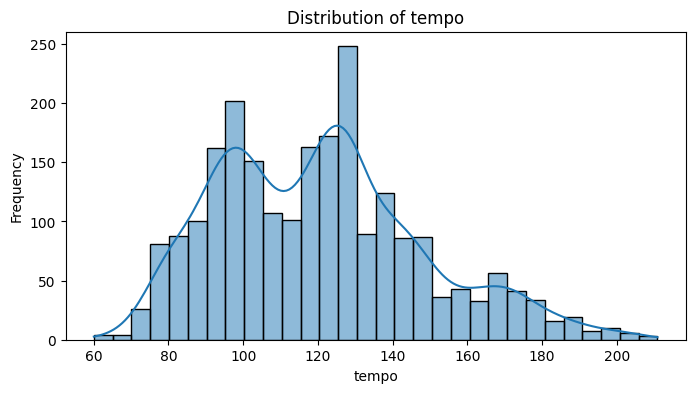

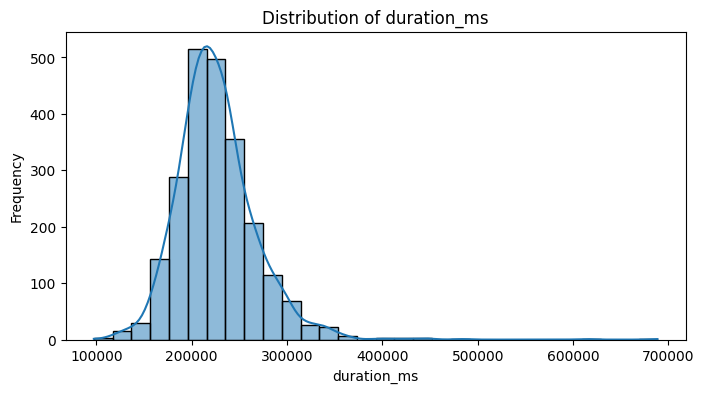

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = [
    'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)  # KDE=True adds density curve
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

columns_to_plot = [
    'track_popularity', 'artist_popularity', 'danceability', 'energy', 'key', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

# Loop through each column and plot
for col in columns_to_plot:
    # Compute histogram data
    hist_values, bin_edges = np.histogram(df[col], bins=30)

    # Compute KDE for smooth density line
    kde = gaussian_kde(df[col])
    x_vals = np.linspace(df[col].min(), df[col].max(), 100)

    # Scale KDE to match the histogram's max frequency
    y_vals = kde(x_vals) * len(df[col]) * (bin_edges[1] - bin_edges[0])

    # Create histogram
    fig = px.histogram(df, x=col, nbins=30, opacity=0.6, title=f'Distribution of {col}',
                       labels={col: col}, histnorm=None)

    # Add KDE line scaled to match frequency
    fig.add_trace(go.Scatter(
        x=x_vals, 
        y=y_vals, 
        mode='lines', 
        line=dict(color='red', width=2),
        name='Density Curve'
    ))

    # Show the figure
    fig.show()

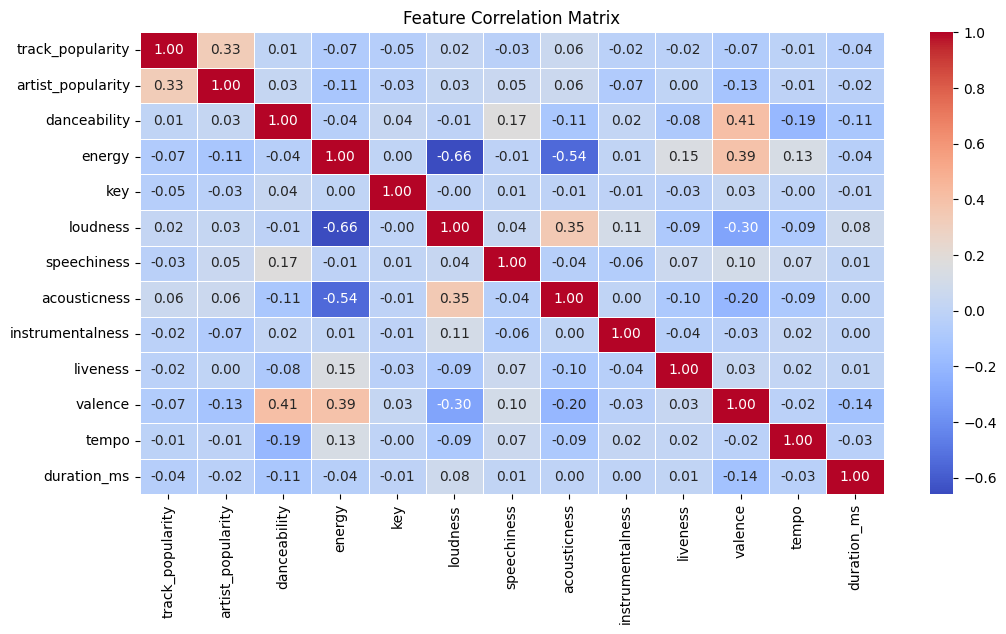

In [46]:
corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

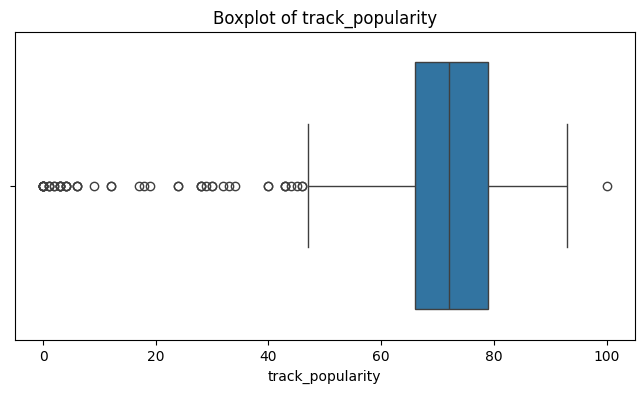

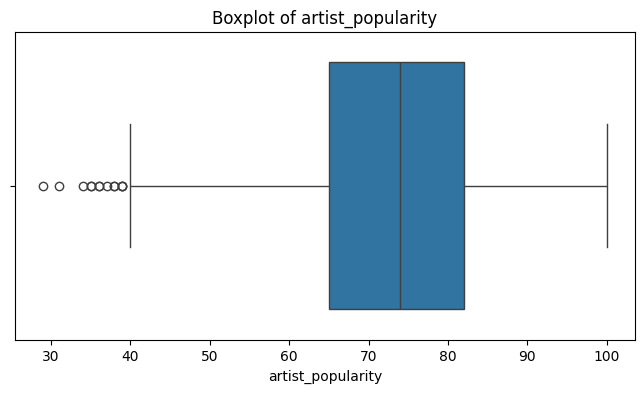

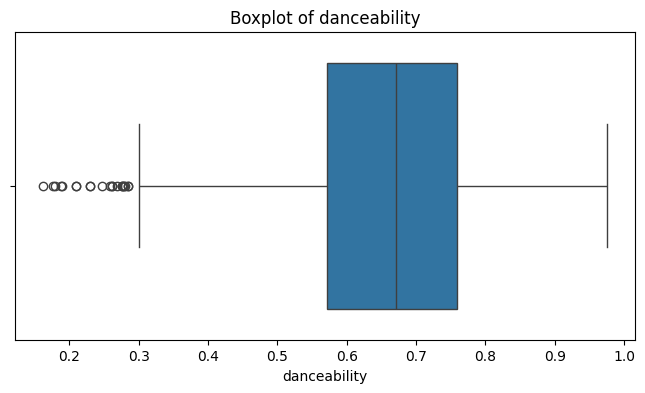

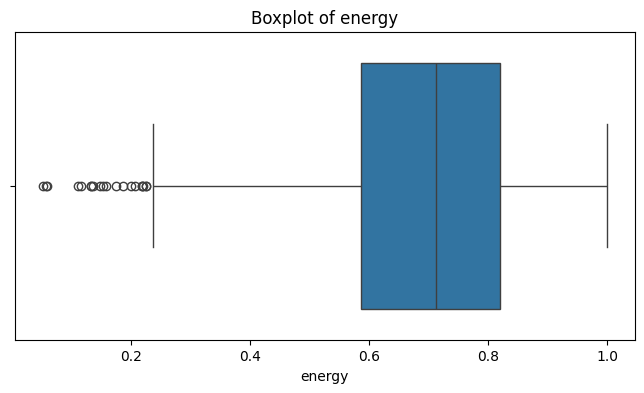

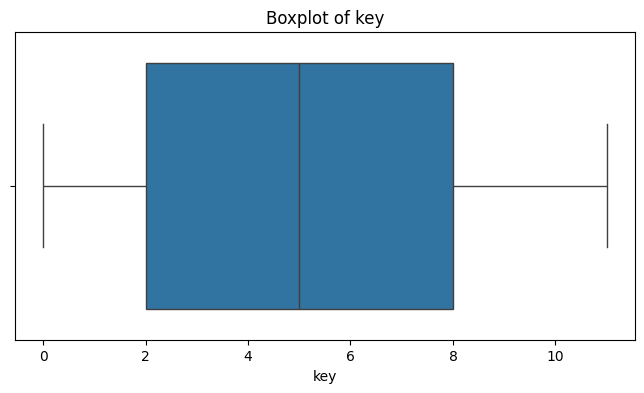

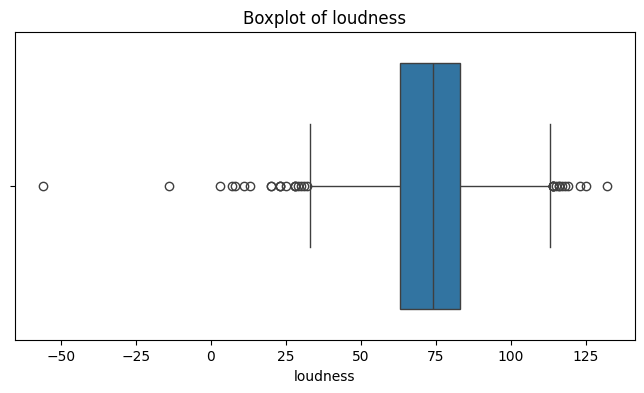

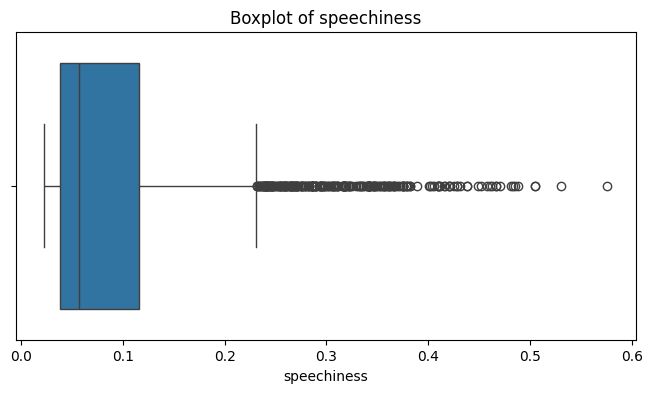

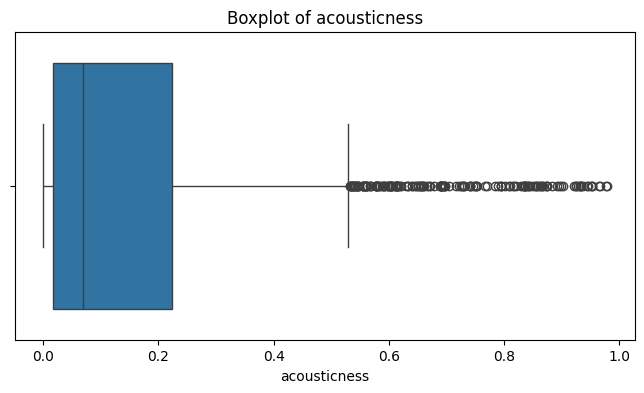

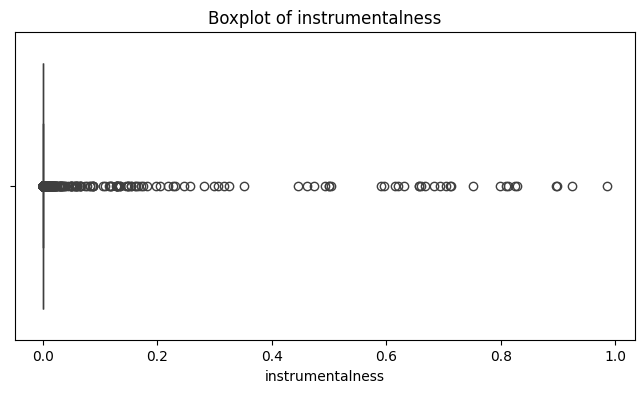

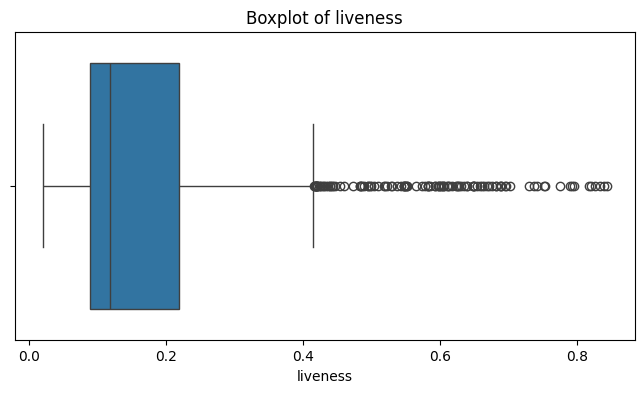

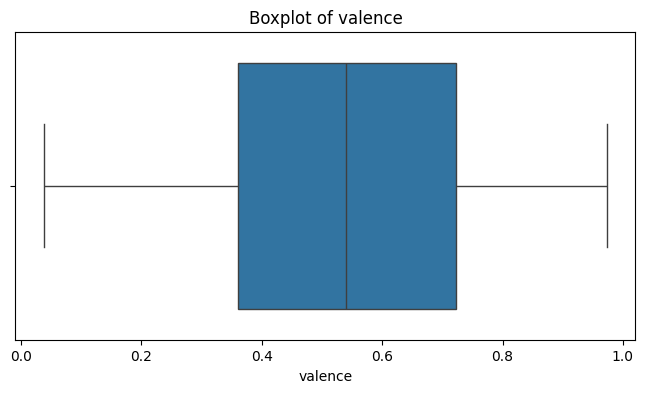

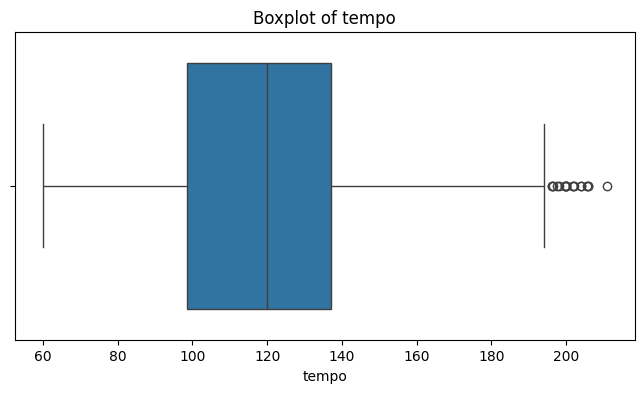

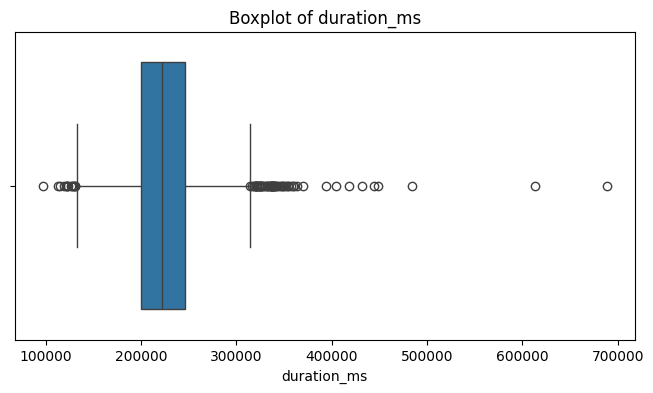

In [47]:
for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [49]:
from scipy.stats import zscore

# Compute Z-scores
z_scores = df[columns_to_plot].apply(zscore)

# Identify outliers (values with Z-score > 3 or < -3)
outliers = (z_scores.abs() > 3).sum()

# Display outliers per feature
outliers

track_popularity     42
artist_popularity     7
danceability          9
energy               13
key                   0
loudness             16
speechiness          43
acousticness         58
instrumentalness     37
liveness             62
valence               0
tempo                 6
duration_ms          17
dtype: int64

EDA / Segmentation (14)

Predictive Model / Model Evaluation (19)

Report (22)